<a href="https://colab.research.google.com/github/RoyVII/cnn-ripple-executable-figure/blob/main/cnn-ripple-false-positive-examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
import numpy as np


In [3]:
#@title **Anaconda installation** { display-mode: "form" }
#@markdown Run this cell to install Anaconda in this notebook (might time some time).

%%capture anaconda
%%bash
cd

MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.10.3-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.anaconda.com/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

In [4]:
#@title **CNN-ripple download and setup** { display-mode: "form" }
#@markdown Run this cell to download and set __CNN-ripple__ (might also take some time).

%%capture install
%%bash
git clone https://github.com/RoyVII/cnn-ripple.git
cd /content/cnn-ripple
conda env create -n cnnrippleenv -f environment.yml
conda activate cnnrippleenv

In [5]:
import os
sys.path.insert(1, '/content/cnn-ripple/figshare')
from figshare import Figshare

fshare = Figshare()

article_id = 20072252 # This is the ID of the data repository

datapath = "figshare_%d"%(article_id)

if os.path.isdir(datapath):
    print("Data already exists. Moving on.")
else:
    print("Downloading data... Please wait")
    fshare.retrieve_files_from_article(article_id)
    print("Data downloaded!")

Data downloaded!


In [6]:
'''''''''''''''''
Load data from the figshare files
'''''''''''''''''
sys.path.insert(1, '/content/cnn-ripple/src/cnn/');
from load_data import load_data

shank = 3

# Load data
print("Loading data...", end=" ")
loaded_data, fs = load_data(path=datapath, shank=shank)
print("Done!")

print("Shape of loaded data: ", np.shape(loaded_data))

Loading data... Done!
Shape of loaded data:  (36097024, 8)


In [7]:
from load_data import z_score_normalization, downsample_data
# Downsample data
downsampled_fs = 1250
print("Downsampling data from %d Hz to %d Hz..."%(fs, downsampled_fs), end=" ")
data = downsample_data(loaded_data, fs, downsampled_fs)
print("Done!")

# Normalize it with z-score
print("Normalizing data...", end=" ")
data = z_score_normalization(data)
print("Done!")

print("Shape of loaded data after downsampling and z-score: ", np.shape(data))

Downsampling data from 30000 Hz to 1250 Hz... Done!
Normalizing data... Done!
Shape of loaded data after downsampling and z-score:  (1504043, 8)


In [8]:
overlapping = True
window_size = 0.0128

print("Generating windows...", end=" ")
if overlapping:
    from load_data import generate_overlapping_windows
    
    stride = 0.0064

    # Separate the data into 12.8ms windows with 6.4ms overlapping
    X = generate_overlapping_windows(data, window_size, stride, downsampled_fs)
else:
    stride = window_size
    X = np.expand_dims(data, 0)
print("Done!")

Generating windows... Done!


In [9]:
import tensorflow.keras.backend as K
import tensorflow.keras as kr

print("Loading CNN model...", end=" ")
optimizer = kr.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
model = kr.models.load_model("/content/cnn-ripple/model", compile=False)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

print("Done!")

Loading CNN model... WARNING:tensorflow:SavedModel saved prior to TF 2.5 detected when loading Keras model. Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), *NOT* tf.saved_model.save(). To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.
Done!


In [10]:
print("Detecting ripples...", end=" ")
predictions = model.predict(X, verbose=True)
print("Done!")

5876/5876 [==============================] - 12s 2ms/step
Done!


In [11]:
from format_predictions import get_predictions_indexes

# This threshold can be changed
threshold = 0.7

print("Getting detected ripples indexes and times...", end=" ")
pred_indexes = get_predictions_indexes(data, predictions, window_size=window_size, stride=stride, fs=downsampled_fs, threshold=threshold)

pred_times = pred_indexes / downsampled_fs
print("Done!")

Getting detected ripples indexes and times... Done!


In [13]:
with open(datapath+'/calb20_false_positives.csv') as csv_file:
    next(csv_file)
    
    all_FP_labels = []
    all_FP_times = []
    pop_iniends = []
    SWn_iniends = []
    SWr_iniends = []
    
    for line in csv_file:
        tokens = line.replace("\n", "").split(",")
        label = int(tokens[-1])
        all_FP_labels.append(label)
        all_FP_times.append([float(tokens[0]), float(tokens[1])])
        
        if label == 1:
            pop_iniends.append([float(tokens[0]), float(tokens[1])])
        elif label == 2:
            SWn_iniends.append([float(tokens[0]), float(tokens[1])])
        elif label == 3:
            SWr_iniends.append([float(tokens[0]), float(tokens[1])])

all_FP_times = np.array(all_FP_times)   
pop_iniends = np.array(pop_iniends)
SWn_iniends = np.array(SWn_iniends)
SWr_iniends = np.array(SWr_iniends)

all_FP_indexes = np.array(all_FP_times * downsampled_fs, dtype=int)
pop_indexes = np.array(pop_iniends * downsampled_fs, dtype=int)
SWn_indexes = np.array(SWn_iniends * downsampled_fs, dtype=int)
SWr_indexes = np.array(SWr_iniends * downsampled_fs, dtype=int)

In [14]:
import matplotlib.pyplot as plt

def create_examples_plot():
    fig = plt.figure(figsize=(20,10))
    
    return fig
    

def add_plot(fig, n, k, pred_indexes, color="tab:blue", title=""):
    data_size = data.shape[0]
    data_dur = data_size / downsampled_fs
    times = np.arange(data_size) / downsampled_fs

    if k > len(pred_indexes):
        return

    mid = (pred_indexes[k, 0] + pred_indexes[k, 1]) / 2.

    ini_idx = int(mid - 0.3 * downsampled_fs)
    end_idx = np.minimum(int(mid + 0.3 * downsampled_fs), data_size-1)

    pos_mat = list(range(data.shape[1]-1, -1, -1)) * np.ones((end_idx-ini_idx, data.shape[1]))
    
    ax = fig.add_subplot(2, 2, n)
    
    ax.set_ylim(-3, 9)
    ax.margins(x=0)
    #plt.tight_layout()
    #plt.xlabel("Time (s)")


    lines = ax.plot(times[ini_idx:end_idx], data[ini_idx:end_idx, :]*1/np.max(data[ini_idx:end_idx, :], axis=0) + pos_mat, color='k', linewidth=1)

    fills = []
    for pred in pred_indexes:
        if (pred[0] >= ini_idx and pred[0] <= end_idx) or (pred[1] >= ini_idx and pred[1] <= end_idx):
            rip_ini = (pred[0]) / downsampled_fs
            rip_end = (pred[1]) / downsampled_fs
            fill = ax.fill_between([rip_ini, rip_end], [-3, -3], [9, 9], color=color, alpha=0.3)
            fills.append(fill)
    
    
    ax.set_title(title)
    ax.tick_params(left = False)
    ax.tick_params(axis='y', colors='w')
    ax.set_xlabel("Time (s)")
    


In [15]:
print("Number of False positives: Population synchrony %d"%(len(pop_indexes)))
print("Number of False positives: SW-noRipple %d"%(len(SWn_indexes)))
print("Number of False positives: SW-Ripple %d"%(len(SWr_indexes)))

Number of False positives: Population synchrony 8
Number of False positives: SW-noRipple 4
Number of False positives: SW-Ripple 11


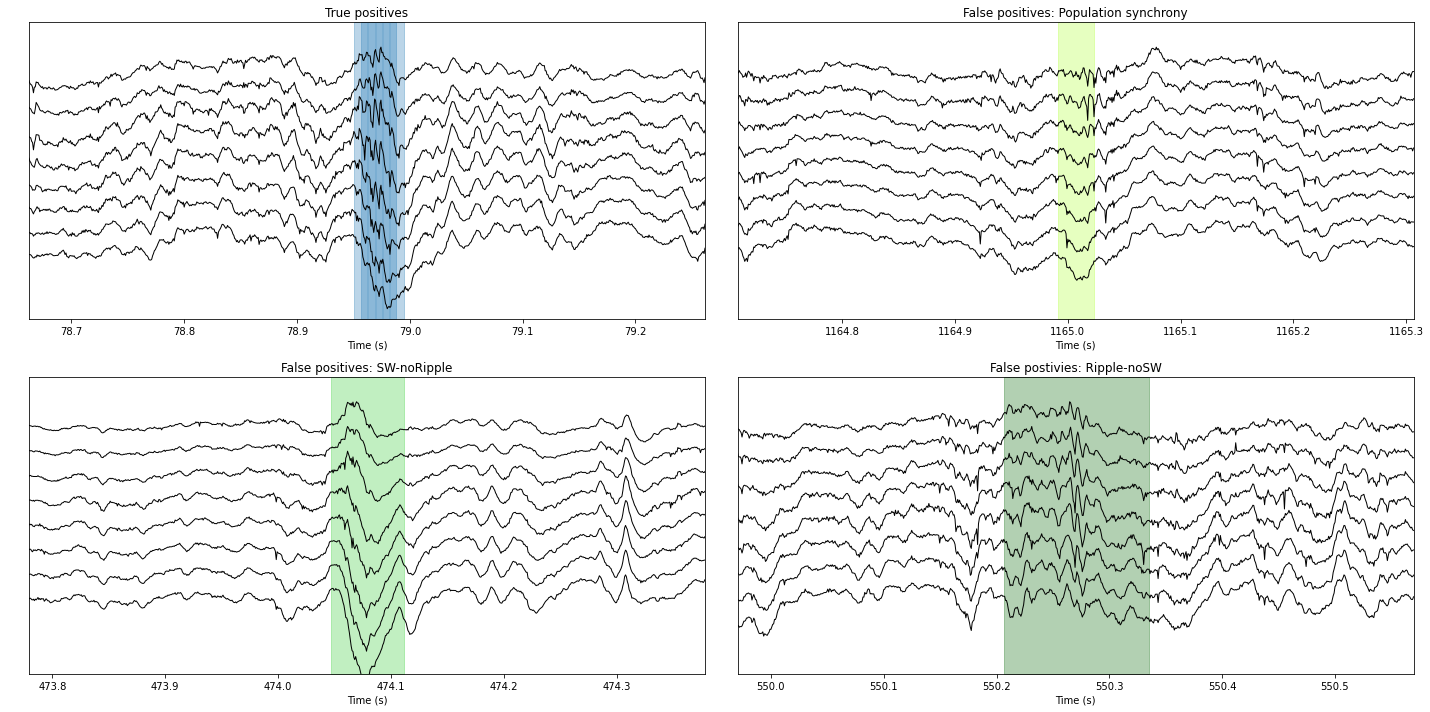

In [19]:
#define figure
fig = create_examples_plot()
idx_tp = 7 # Index of the displayed TP
idx_pop = 113 # Index of the displayed FP population synchrony
idx_SWn = 39 # Index of the displayed FP SW-noRipple
idx_SWr = 42 # Index of the displayed FP Ripple-noSW

#add subplots
add_plot(fig, 1, 7, pred_indexes, color="tab:blue", title="True positives")
add_plot(fig, 2, 113, all_FP_indexes, color="greenyellow", title="False positives: Population synchrony")
add_plot(fig, 3, 39, all_FP_indexes, color="limegreen", title="False positives: SW-noRipple")
add_plot(fig, 4, 42, all_FP_indexes, color="darkgreen", title="False postivies: Ripple-noSW")

#display plots
plt.tight_layout()
plt.show()